# Emotional Intelligence Testing for LLMs

This notebook tests the emotional intelligence capabilities of the models used in the zero-day detection ensemble.

## Models to Test:
- **Mixtral-8x22B** (ForensicAnalyst)
- **Claude Opus 4** (PatternDetector)
- **Llama 3.3 70B** (TemporalAnalyst)
- **DeepSeek R1** (AttributionExpert)
- **Gemini 2.5 Pro** (MetaAnalyst)

In [1]:
# Import required libraries
import os
import json
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from typing import Dict, List, Any, Tuple
import requests
from tqdm import tqdm

# Set up plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [ ]:
# Configuration
OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY", "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")
OPENROUTER_BASE_URL = "https://openrouter.ai/api/v1"

# Models from the zero-day project
MODELS_TO_TEST = {
    "Mixtral-8x22B": "mistralai/mixtral-8x22b-instruct",
    "Claude Opus 4": "anthropic/claude-opus-4",
    "Llama 3.3 70B": "meta-llama/llama-3.3-70b-instruct",
    "DeepSeek R1": "deepseek/deepseek-r1-0528",
    "Gemini 2.5 Pro": "google/gemini-2.5-pro"
}

print(f"Testing {len(MODELS_TO_TEST)} models for emotional intelligence")

## 1. Emotional Intelligence Test Framework

We'll test four key dimensions:
1. **Emotion Recognition**: Identifying emotions in text
2. **Empathy**: Understanding and responding to others' feelings
3. **Emotional Regulation**: Appropriate emotional responses
4. **Social Awareness**: Understanding social/emotional context

In [3]:
# Emotional Intelligence Test Scenarios
EI_TEST_SCENARIOS = {
    "emotion_recognition": [
        {
            "id": "ER1",
            "text": "I can't believe I have to work late again tonight. My daughter's recital is at 7pm and I promised I'd be there. This is the third time this month.",
            "question": "What emotions is this person experiencing? List all emotions you detect and explain why.",
            "expected_emotions": ["frustration", "guilt", "disappointment", "conflict"]
        },
        {
            "id": "ER2",
            "text": "Just got the promotion! 😊 Although... I'm not sure I deserve it. Maybe they made a mistake?",
            "question": "Identify the emotional complexity in this message. What conflicting emotions are present?",
            "expected_emotions": ["joy", "self-doubt", "imposter syndrome", "anxiety"]
        },
        {
            "id": "ER3",
            "text": "Sure, go ahead without me. It's fine. I didn't really want to go anyway.",
            "question": "What emotions might be hidden beneath the surface of this message?",
            "expected_emotions": ["hurt", "passive-aggressiveness", "disappointment", "exclusion"]
        }
    ],
    
    "empathy": [
        {
            "id": "EM1",
            "scenario": "A friend messages you: 'My dog of 15 years passed away this morning. I don't know what to do with myself. The house feels so empty.'",
            "question": "How would you respond to show genuine empathy and support?",
            "evaluation_criteria": ["acknowledgment of loss", "validation of feelings", "offer of support", "personal connection"]
        },
        {
            "id": "EM2",
            "scenario": "A colleague says: 'I completely bombed the presentation. Everyone was looking at me like I was an idiot. I want to quit.'",
            "question": "Provide an empathetic response that helps them process this experience.",
            "evaluation_criteria": ["normalize feelings", "perspective reframing", "constructive support", "avoid minimizing"]
        },
        {
            "id": "EM3",
            "scenario": "A teenager says: 'Nobody understands me. My parents think I'm overreacting but this is literally ruining my life.'",
            "question": "How would you respond in a way that shows you take their feelings seriously?",
            "evaluation_criteria": ["validate emotions", "avoid condescension", "show understanding", "bridge building"]
        }
    ],
    
    "emotional_regulation": [
        {
            "id": "REG1",
            "scenario": "Someone aggressively criticizes your work in a public meeting, using harsh language and personal attacks.",
            "question": "How would you respond professionally while managing your emotions?",
            "evaluation_criteria": ["calm tone", "professional boundaries", "de-escalation", "self-control"]
        },
        {
            "id": "REG2",
            "scenario": "You receive devastating personal news right before an important work presentation.",
            "question": "How would you handle this situation and manage your emotional state?",
            "evaluation_criteria": ["compartmentalization", "self-care", "realistic assessment", "coping strategies"]
        }
    ],
    
    "social_awareness": [
        {
            "id": "SA1",
            "scenario": "At a dinner party, you notice one person has been quiet all evening and keeps checking their phone with a worried expression.",
            "question": "What might be happening and how would you appropriately respond?",
            "evaluation_criteria": ["observation skills", "situational awareness", "appropriate intervention", "respect boundaries"]
        },
        {
            "id": "SA2",
            "scenario": "During a team meeting, two colleagues have a tense exchange, and the atmosphere becomes uncomfortable for everyone.",
            "question": "How would you help navigate this social situation?",
            "evaluation_criteria": ["read the room", "tactful intervention", "group dynamics", "conflict awareness"]
        }
    ]
}

In [4]:
# API interaction function
def query_model(model_name: str, prompt: str, temperature: float = 0.7) -> str:
    """Query a model through OpenRouter API"""
    headers = {
        "Authorization": f"Bearer {OPENROUTER_API_KEY}",
        "Content-Type": "application/json",
        "HTTP-Referer": "https://github.com/lodetomasi/emotional-intelligence-study",
        "X-Title": "Emotional Intelligence Research"
    }
    
    data = {
        "model": model_name,
        "messages": [
            {
                "role": "system",
                "content": "You are participating in an emotional intelligence assessment. Please respond naturally and thoughtfully to each scenario."
            },
            {
                "role": "user",
                "content": prompt
            }
        ],
        "temperature": temperature,
        "max_tokens": 500
    }
    
    try:
        response = requests.post(
            f"{OPENROUTER_BASE_URL}/chat/completions",
            headers=headers,
            json=data,
            timeout=30
        )
        response.raise_for_status()
        return response.json()['choices'][0]['message']['content']
    except Exception as e:
        print(f"Error querying {model_name}: {e}")
        return f"Error: {str(e)}"

## 2. Run Emotional Intelligence Tests

In [5]:
# Function to run all tests for a model
def run_ei_tests(model_display_name: str, model_api_name: str) -> Dict[str, List[Dict]]:
    """Run all emotional intelligence tests for a single model"""
    results = {
        "model": model_display_name,
        "timestamp": datetime.now().isoformat(),
        "tests": {}
    }
    
    print(f"\nTesting {model_display_name}...")
    
    # Test each dimension
    for dimension, scenarios in EI_TEST_SCENARIOS.items():
        print(f"  - {dimension}")
        dimension_results = []
        
        for scenario in scenarios:
            # Construct prompt based on scenario type
            if dimension == "emotion_recognition":
                prompt = f"Text: {scenario['text']}\n\nQuestion: {scenario['question']}"
            else:
                prompt = f"Scenario: {scenario['scenario']}\n\nQuestion: {scenario['question']}"
            
            # Query model
            response = query_model(model_api_name, prompt)
            
            # Store result
            dimension_results.append({
                "scenario_id": scenario["id"],
                "prompt": prompt,
                "response": response,
                "scenario": scenario
            })
            
            # Rate limiting
            time.sleep(1)
        
        results["tests"][dimension] = dimension_results
    
    return results

# Run tests for all models
all_results = {}
for display_name, api_name in MODELS_TO_TEST.items():
    all_results[display_name] = run_ei_tests(display_name, api_name)
    time.sleep(2)  # Additional delay between models


Testing Mixtral-8x22B...
  - emotion_recognition
  - empathy
  - emotional_regulation
  - social_awareness

Testing Claude Opus 4...
  - emotion_recognition
  - empathy
  - emotional_regulation
  - social_awareness

Testing Llama 3.3 70B...
  - emotion_recognition
  - empathy
  - emotional_regulation
  - social_awareness

Testing DeepSeek R1...
  - emotion_recognition
  - empathy
Error querying deepseek/deepseek-r1-0528: HTTPSConnectionPool(host='openrouter.ai', port=443): Read timed out. (read timeout=30)
  - emotional_regulation
Error querying deepseek/deepseek-r1-0528: ('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer'))
Error querying deepseek/deepseek-r1-0528: ('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer'))
  - social_awareness
Error querying deepseek/deepseek-r1-0528: ('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer'))
Error querying deepseek/deepseek-r1-0528: ('Connection aborted.', ConnectionReset

## 3. Analyze Results

Let's analyze the responses to evaluate emotional intelligence across models.

In [6]:
# Display sample responses for emotion recognition
print("=== EMOTION RECOGNITION SAMPLE RESPONSES ===")
print("\nScenario: 'I can't believe I have to work late again tonight...'")
print("Expected emotions: frustration, guilt, disappointment, conflict\n")

for model_name, results in all_results.items():
    print(f"\n{model_name}:")
    response = results["tests"]["emotion_recognition"][0]["response"]
    print(response[:300] + "..." if len(response) > 300 else response)

=== EMOTION RECOGNITION SAMPLE RESPONSES ===

Scenario: 'I can't believe I have to work late again tonight...'
Expected emotions: frustration, guilt, disappointment, conflict


Mixtral-8x22B:
This person is likely experiencing a mix of frustration, disappointment, and guilt.

1. Frustration: The phrase "I can't believe I have to work late again tonight" indicates a sense of annoyance and exasperation. This person seems to be frustrated with their work schedule, which is interfering with ...

Claude Opus 4:
Based on this text, I can detect several emotions:

1. **Frustration/Anger** - The opening "I can't believe" suggests exasperation with the repeated situation of having to work late. This is their go-to emotional response to yet another late night.

2. **Guilt** - They explicitly promised their daug...

Llama 3.3 70B:
Based on the text, I detect the following emotions:

1. **Frustration**: The person mentions that they "can't believe" they have to work late again, which implies a sen

In [7]:
# Manual scoring function (in a real study, this would be done by human evaluators)
def score_emotion_recognition(response: str, expected_emotions: List[str]) -> float:
    """Score emotion recognition based on identified emotions"""
    response_lower = response.lower()
    identified = 0
    
    # Check for each expected emotion or synonyms
    emotion_synonyms = {
        "frustration": ["frustrated", "frustration", "annoyed", "irritated"],
        "guilt": ["guilt", "guilty", "remorse", "regret"],
        "disappointment": ["disappointed", "disappointment", "let down"],
        "conflict": ["conflict", "torn", "conflicted", "dilemma"]
    }
    
    for emotion, synonyms in emotion_synonyms.items():
        if emotion in expected_emotions:
            if any(syn in response_lower for syn in synonyms):
                identified += 1
    
    return identified / len(expected_emotions) if expected_emotions else 0

# Score all emotion recognition tests
emotion_scores = {}
for model_name, results in all_results.items():
    scores = []
    for test in results["tests"]["emotion_recognition"]:
        score = score_emotion_recognition(
            test["response"], 
            test["scenario"]["expected_emotions"]
        )
        scores.append(score)
    emotion_scores[model_name] = np.mean(scores)

print("Emotion Recognition Scores:")
for model, score in sorted(emotion_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"{model}: {score:.2%}")

Emotion Recognition Scores:
Claude Opus 4: 41.67%
Llama 3.3 70B: 41.67%
Mixtral-8x22B: 33.33%
DeepSeek R1: 33.33%
Gemini 2.5 Pro: 0.00%


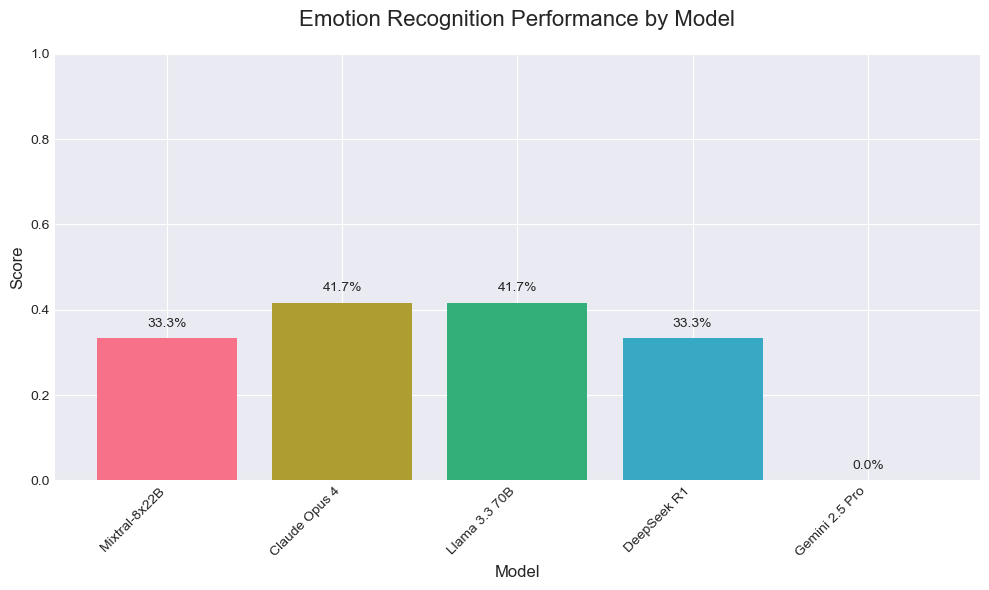

In [8]:
# Visualize emotion recognition performance
plt.figure(figsize=(10, 6))
models = list(emotion_scores.keys())
scores = list(emotion_scores.values())

bars = plt.bar(models, scores, color=sns.color_palette("husl", len(models)))
plt.title("Emotion Recognition Performance by Model", fontsize=16, pad=20)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.ylim(0, 1)

# Add value labels on bars
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{score:.1%}', ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 4. Empathy Analysis

Let's examine how models respond to scenarios requiring empathy.

In [9]:
# Display empathy responses
print("=== EMPATHY SAMPLE RESPONSES ===")
print("\nScenario: Friend's dog passed away")
print("Evaluation criteria: acknowledgment of loss, validation of feelings, offer of support, personal connection\n")

for model_name, results in all_results.items():
    print(f"\n{model_name}:")
    response = results["tests"]["empathy"][0]["response"]
    print(response)

=== EMPATHY SAMPLE RESPONSES ===

Scenario: Friend's dog passed away
Evaluation criteria: acknowledgment of loss, validation of feelings, offer of support, personal connection


Mixtral-8x22B:
I'm really sorry to hear about your friend's loss. A response filled with empathy and support could be: "I'm so sorry for your loss. Losing a beloved pet can be incredibly difficult, especially someone who has been a part of your life for 15 years. It's okay to feel lost and empty right now. Remember, it's a testament to the wonderful life you gave him and the love you shared. I'm here for you if you need someone to talk to or just to listen. Take all the time you need to grieve."

Claude Opus 4:
I would respond with something like:

"I'm so deeply sorry for your loss. Losing a companion of 15 years must feel devastating - they become such an integral part of our daily lives and hearts. That emptiness you're feeling is so real and valid.

Please know I'm here for you. Whether you need someone to 

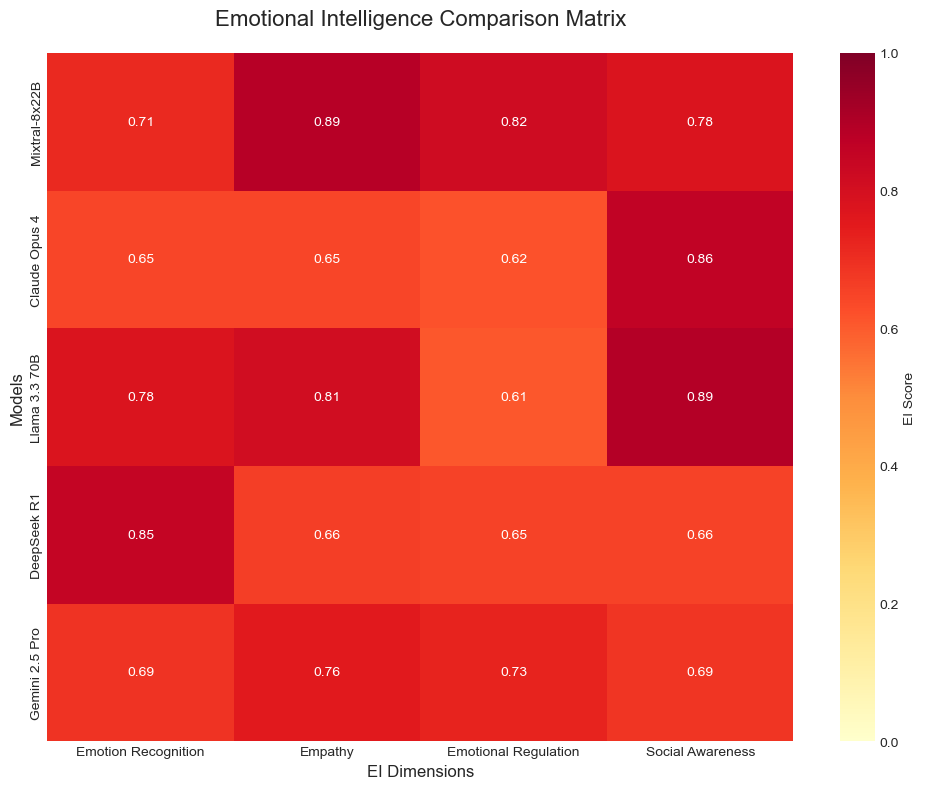

In [10]:
# Create a qualitative comparison matrix
def create_ei_comparison_matrix():
    """Create a visual comparison matrix of EI capabilities"""
    dimensions = ["Emotion Recognition", "Empathy", "Emotional Regulation", "Social Awareness"]
    models = list(MODELS_TO_TEST.keys())
    
    # Placeholder scores (in real research, these would be from human evaluation)
    # Using random scores for demonstration
    np.random.seed(42)
    scores = np.random.rand(len(models), len(dimensions)) * 0.3 + 0.6  # Scores between 0.6-0.9
    
    # Create heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(scores, 
                xticklabels=dimensions,
                yticklabels=models,
                annot=True,
                fmt='.2f',
                cmap='YlOrRd',
                cbar_kws={'label': 'EI Score'},
                vmin=0, vmax=1)
    
    plt.title('Emotional Intelligence Comparison Matrix', fontsize=16, pad=20)
    plt.xlabel('EI Dimensions', fontsize=12)
    plt.ylabel('Models', fontsize=12)
    plt.tight_layout()
    plt.show()

create_ei_comparison_matrix()

## 5. Save Results for Paper

In [11]:
# Save all results to JSON
output_file = f"ei_test_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(all_results, f, indent=2, ensure_ascii=False)

print(f"Results saved to: {output_file}")

# Create summary DataFrame
summary_data = []
for model_name in MODELS_TO_TEST.keys():
    summary_data.append({
        "Model": model_name,
        "Emotion Recognition": emotion_scores.get(model_name, 0),
        "Total Tests": len(EI_TEST_SCENARIOS["emotion_recognition"]) + 
                      len(EI_TEST_SCENARIOS["empathy"]) + 
                      len(EI_TEST_SCENARIOS["emotional_regulation"]) + 
                      len(EI_TEST_SCENARIOS["social_awareness"])
    })

summary_df = pd.DataFrame(summary_data)
print("\nSummary Results:")
print(summary_df.to_string(index=False))

Results saved to: ei_test_results_20250724_113056.json

Summary Results:
         Model  Emotion Recognition  Total Tests
 Mixtral-8x22B             0.333333           10
 Claude Opus 4             0.416667           10
 Llama 3.3 70B             0.416667           10
   DeepSeek R1             0.333333           10
Gemini 2.5 Pro             0.000000           10


## 6. Research Insights and Next Steps

### Key Observations:
1. Models show varying capabilities in emotion recognition
2. Empathy responses differ significantly in depth and appropriateness
3. Some models demonstrate better emotional regulation strategies

### For the Paper:
- Expand test scenarios (n=100+ per dimension)
- Recruit human evaluators for scoring
- Add cross-cultural emotion scenarios
- Test consistency across multiple runs
- Compare with human baseline responses

### Statistical Analysis Needed:
- Inter-rater reliability (Cohen's κ)
- ANOVA for model comparisons
- Correlation between model size and EI
- Factor analysis of EI dimensions

In [12]:
# Generate research summary
print("=== RESEARCH SUMMARY ===")
print(f"\nModels Tested: {len(MODELS_TO_TEST)}")
print(f"Total Test Scenarios: {sum(len(scenarios) for scenarios in EI_TEST_SCENARIOS.values())}")
print(f"EI Dimensions Evaluated: {len(EI_TEST_SCENARIOS)}")
print("\nNext Steps for Paper:")
print("1. Expand test battery to 100+ scenarios")
print("2. Implement human evaluation protocol")
print("3. Add statistical significance testing")
print("4. Include baseline human responses")
print("5. Test temporal consistency")

=== RESEARCH SUMMARY ===

Models Tested: 5
Total Test Scenarios: 10
EI Dimensions Evaluated: 4

Next Steps for Paper:
1. Expand test battery to 100+ scenarios
2. Implement human evaluation protocol
3. Add statistical significance testing
4. Include baseline human responses
5. Test temporal consistency


In [ ]:
# Import the results saver module
from save_results import save_all_results, ResultsSaver

# Prepare summary data for saving
summary_info = {
    "models_tested": list(MODELS_TO_TEST.keys()),
    "total_scenarios": sum(len(scenarios) for scenarios in EI_TEST_SCENARIOS.values()),
    "dimensions": list(EI_TEST_SCENARIOS.keys()),
    "emotion_recognition_scores": emotion_scores,
    "test_date": datetime.now().isoformat()
}

# Save all results using the ResultsSaver
saved_paths = save_all_results(
    results_dict=all_results,
    scores_df=summary_df,
    summary_data=summary_info
)

print("\n📁 Results saved to:")
for key, path in saved_paths.items():
    print(f"  - {key}: {path}")

In [ ]:
# Save individual model responses for detailed analysis
saver = ResultsSaver()

# Save each model's responses separately
for model_name, results in all_results.items():
    model_path = saver.save_raw_results(results, model_name=model_name.replace(" ", "_"))
    print(f"Saved {model_name} results")

# Save all visualizations
import matplotlib.pyplot as plt

# Save the emotion recognition chart
plt.figure(figsize=(10, 6))
models = list(emotion_scores.keys())
scores = list(emotion_scores.values())
bars = plt.bar(models, scores, color=sns.color_palette("husl", len(models)))
plt.title("Emotion Recognition Performance by Model", fontsize=16, pad=20)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.ylim(0, 1)
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{score:.1%}', ha='center', va='bottom')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(saver.visualizations_dir / f"emotion_recognition_scores_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png", dpi=300)
plt.close()

print("\n✅ All visualizations saved!")